In [113]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [256]:
fname = "2020_10_29.hdf"
dset_name = "1604012796 rotational cooling ratio _ rc laser through center window"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [257]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [258]:
indices_filtered = []
for idx in range(1,len(pxie)+1):
    # check if laser is actually on by comparing background signal
    if np.mean(pxie[idx][:,1]) < -3000:
        indices_filtered.append(idx)

In [259]:
shutter_state = {'open': [], 'closed':[]}
for idx in indices_filtered:
    if np.mean(pxie[idx].T[2][:10]) > 2e4:
        shutter_state['open'].append(idx)
    else:
        shutter_state['closed'].append(idx)
        
shutter_state['open'] = np.array(shutter_state['open'])
shutter_state['closed'] = np.array(shutter_state['closed'])

In [260]:
data_grouped = {'open': [], 'closed': []}
for idx in shutter_state['open']:
    data_grouped['open'].append(pxie[idx][:,1])
for idx in shutter_state['closed']:
    data_grouped['closed'].append(pxie[idx][:,1])
    
data_grouped['open'] = np.array(data_grouped['open'])
data_grouped['closed'] = np.array(data_grouped['closed'])

In [537]:
data_filtered = {'open': [], 'closed': []}
for dat in data_grouped['open']:
    y = dat.copy().astype(float)
    y -= np.mean(np.append(y[:250], y[-100:]))
    data_filtered['open'].append(-y)
for dat in data_grouped['closed']:
    y = dat.copy().astype(float)
    y -= np.mean(np.append(y[:250], y[-100:]))
    data_filtered['closed'].append(-y)
    
for key, val in filtered_data.items():
    data_filtered[key] = np.array(val)

integral ratio : 3.10702 +/- 0.21434


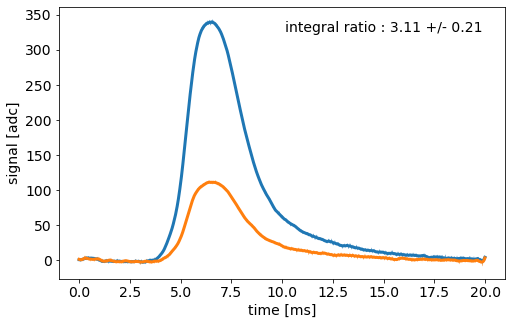

In [423]:
yo = np.mean(data_grouped['open'], axis = 0)
yc = np.mean(data_grouped['closed'], axis = 0)
yo -= np.mean(yo[:300])
yc -= np.mean(yc[:300])

lo = len(data_grouped['open'])
lc = len(data_grouped['closed'])

syo = np.std(data_grouped['open'], axis = 0)
syo /= np.sqrt(lo)
syc = np.std(data_grouped['closed'], axis = 0)
syc /= np.sqrt(lc)

x = np.linspace(0,1999,2000)/100

trapzo = np.trapz(-yo)
trapzc = np.trapz(-yc)
trapz_error = (trapzo/trapzc)*np.sqrt((np.sum(syo)/trapzo)**2 + (np.sum(syc)/trapzc)**2)


fig, ax = plt.subplots(figsize = (8,5))

ax.fill_between(x, -yo-syo, -yo+syo, alpha = .7)
ax.fill_between(x, -yc-syc, -yc+syc, alpha = .7)
ax.plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
ax.plot(x, -savgol_filter(yc, 51, 3), lw = 3, label= 'rc off')
ax.set_xlabel('time [ms]')
ax.set_ylabel('signal [adc]')
text = f'integral ratio : {np.trapz(-yo)/np.trapz(-yc):.2f} +/- {trapz_error:.2f}'
ax.text(0.95, 0.95, text, transform = ax.transAxes, fontsize = 14, ha = 'right',
        va = 'top')


print(f'integral ratio : {np.trapz(-yo)/np.trapz(-yc):.5f} +/- {trapz_error:.5f}')

set_fontsize(ax, 14)

We release the Qswitch inhibit every 40 shots, so this means the order of shutter open/close can change every 40 shots. For future ease of use just set the total number of shots to let through in one go.

In [288]:
group_by = 20

split_shutter_state = {}
for key, val in shutter_state.items():
    split_shutter_state[key] = np.array(np.array_split(val, len(val)//group_by))

### Averaging bunches together for calculating the ratio 

In [702]:
ch = 1
ratios = []
ratios_errors = []

for idx_open, idx_closed in zip(split_shutter_state['open'], split_shutter_state['closed']):
    d_open = -np.array([pxie[idx][:,ch] for idx in idx_open]).astype(float)
    d_closed = -np.array([pxie[idx][:,ch] for idx in idx_closed]).astype(float)
    d_open -= np.mean(d_open[:,:250], axis = 1)[:, np.newaxis]
    d_closed -= np.mean(d_closed[:,:250], axis = 1)[:, np.newaxis]

    int_open_error = np.sum(np.std(d_open, axis = 1))
    int_closed_error = np.sum(np.std(d_closed, axis = 1))
    d_closed = d_closed.mean(axis = 1)
    d_open = d_open.mean(axis = 1)
    
    int_open = np.trapz(d_open)
    int_closed = np.trapz(d_closed)

    
    ratio = int_open/int_closed
    ratio_errors = np.abs(ratio*np.sqrt((int_open/int_open_error)**2+(int_closed/int_closed_error)**2))
    
    ratios.append(ratio)
    ratios_errors.append(ratio_errors)
    
ratios = np.array(ratios)
ratios_errors = np.array(ratios_errors)

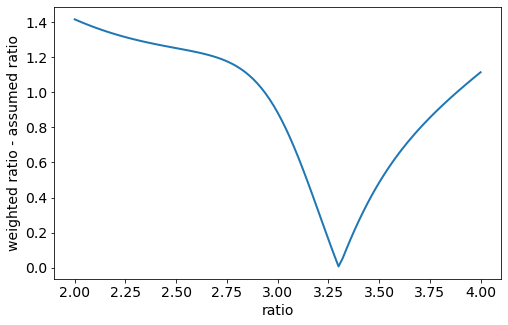

In [703]:
true_ratios = np.linspace(2,4,101)
results = []
for true_ratio in true_ratios:
    scaled_error = ratios_errors.copy()
#     scaled_error = np.zeros(len(ratios))
    scaled_error += 1/np.abs(ratios - true_ratio)**2
    ratio_mean = np.average(ratios, weights = 1/(scaled_error**2))
    ratio_mean_error = np.sqrt(1/np.sum(1/ratios_errors**2))
#     print(f'true ratio : {true_ratio:.2f} -> {ratio_mean:.2f} +/- {ratio_mean_error:.2f}' )
    results.append(ratio_mean)
    
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(true_ratios, np.abs(results - true_ratios), lw = 2)

ax.set_xlabel('ratio')
ax.set_ylabel('weighted ratio - assumed ratio')

set_fontsize(ax, 14)

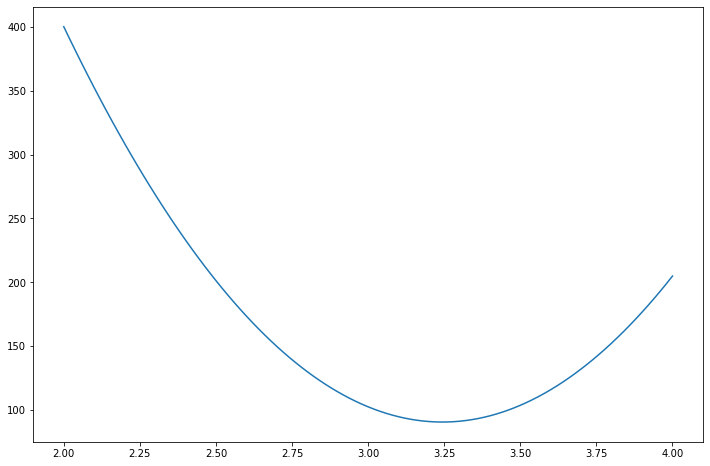

In [704]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(true_ratios, np.sum((ratios[:,np.newaxis] - true_ratios[np.newaxis,:])**2, axis = 0))

In [641]:
ratio_mean = np.average(ratios, weights = 1/(ratios_errors)**2)
ratio_mean_error = np.sqrt(1/np.sum(1/ratios_errors**2))
print(ratio_mean, ratio_mean_error)

3.0798266484323706 0.11848924862033862


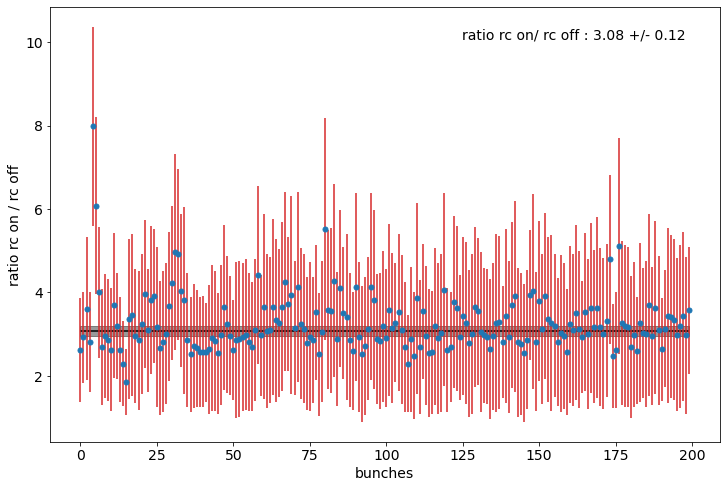

In [643]:
x = np.arange(len(ratios))
mean = ratio_mean
sigma = ratio_mean_error

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x, ratios, yerr = ratios_errors, fmt = '.', 
            ecolor = 'C3', ms = 10)

ax.hlines(mean, xmin = x.min(), xmax = x.max(), color = 'k', zorder = 0)
ax.fill_between(x, mean - sigma, mean+sigma, zorder = 0, alpha = 0.4, color = 'k')

ax.set_xlabel('bunches')
ax.set_ylabel('ratio rc on / rc off')

text = f'ratio rc on/ rc off : {ratio_mean:.2f} +/- {ratio_mean_error:.2f}'
ax.text(0.95, 0.95, text, transform = ax.transAxes, fontsize = 14, ha = 'right',
        va = 'top')

set_fontsize(ax, 14)

Because the error of a ratio x/y scales with the ratio x/y (along with the errors in x and y), weighted averaging using this averaging will tend to the smaller ratios.

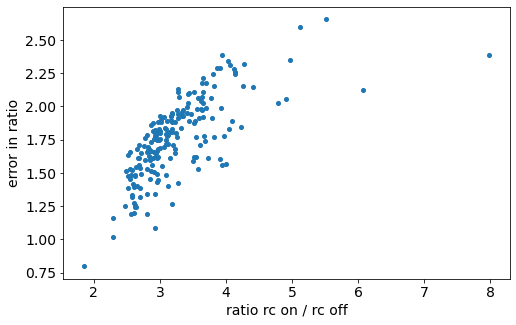

In [644]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(ratios, ratios_errors, '.', ms = 8)
ax.set_xlabel('ratio rc on / rc off')
ax.set_ylabel('error in ratio')

set_fontsize(ax, 14)

### Single ratios

In [707]:
σ = 75
ch = 1
ratios = []
ratios_errors = []

for idx_open, idx_closed in zip(split_shutter_state['open'], split_shutter_state['closed']):
    d_open = -np.array([pxie[idx][:,ch] for idx in idx_open]).astype(float)
    d_closed = -np.array([pxie[idx][:,ch] for idx in idx_closed]).astype(float)
    d_open -= np.mean(d_open[:,:250], axis = 1)[:, np.newaxis]
    d_closed -= np.mean(d_closed[:,:250], axis = 1)[:, np.newaxis]
    
    int_open = np.trapz(d_open, axis = 1)
    int_closed = np.trapz(d_closed, axis = 1)
    int_open_error = σ*d_open.shape[1]
    int_closed_error = σ*d_open.shape[1]
    
    int_open = np.array([val if val > 5e3 else np.nan for val in int_open])
    int_closed = np.array([val if val > 5e3 else np.nan for val in int_closed])
    
    ratio = int_open/int_closed
    ratio_errors = np.abs(ratio)*np.sqrt((int_open/int_open_error)**2+(int_closed/int_closed_error)**2)
    
    ratios.extend(ratio)
    ratios_errors.extend(ratio_errors)
    
ratios = np.array(ratios)
ratios_errors = np.array(ratios_errors)

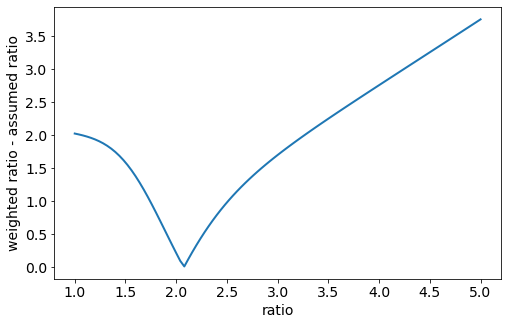

In [708]:
m = (~np.isnan(ratios))

true_ratios = np.linspace(1,5,101)
results = []
for true_ratio in true_ratios:
    scaled_error = ratios_errors[m].copy()
#     scaled_error = np.zeros(m.sum())
    scaled_error += 1/np.abs(ratios[m] - true_ratio)**2
    ratio_mean = np.average(ratios[m], weights = 1/(scaled_error**2))
    ratio_mean_error = np.sqrt(1/np.sum(1/ratios_errors[m]**2))
    results.append(ratio_mean)
    
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(true_ratios, np.abs(results - true_ratios), lw = 2)

ax.set_xlabel('ratio')
ax.set_ylabel('weighted ratio - assumed ratio')

set_fontsize(ax, 14)

In [694]:
m = (~np.isnan(ratios))
ratio_mean = np.average(ratios[m], weights = 1/(ratios_errors[m])**2)
ratio_mean_error = np.sqrt(1/np.sum(1/ratios_errors[m]**2))
print(ratio_mean, ratio_mean_error)

1.1341054870993177 0.018739178610627037


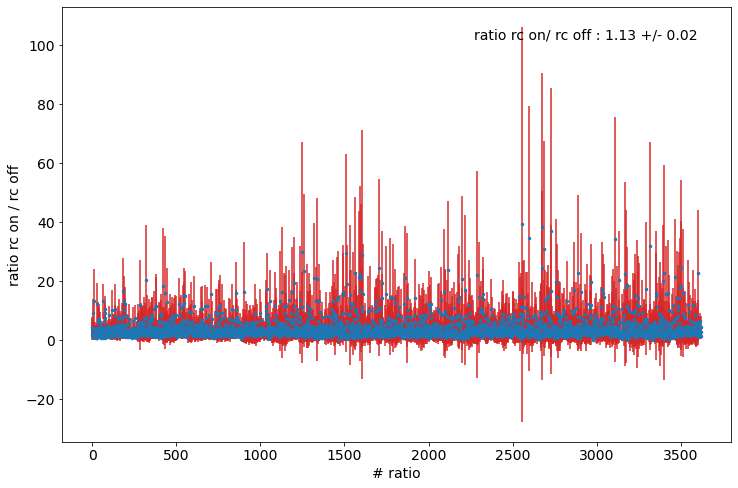

In [568]:
x = np.arange(len(ratios[m]))
mean = ratio_mean
sigma = ratio_mean_error

fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x, ratios[m], yerr = ratios_errors[m], fmt = '.', 
            ecolor = 'C3', ms = 5)

ax.hlines(mean, xmin = x.min(), xmax = x.max(), color = 'k', zorder = 0)
ax.fill_between(x, mean - sigma, mean+sigma, zorder = 0, alpha = 0.4, color = 'k')

ax.set_xlabel('# ratio')
ax.set_ylabel('ratio rc on / rc off')

text = f'ratio rc on/ rc off : {ratio_mean:.2f} +/- {ratio_mean_error:.2f}'
ax.text(0.95, 0.95, text, transform = ax.transAxes, fontsize = 14, ha = 'right',
        va = 'top')

set_fontsize(ax, 14)

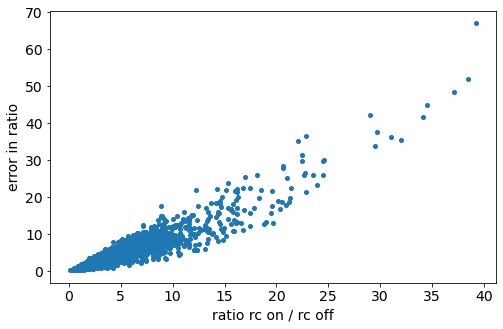

In [563]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(ratios, ratios_errors, '.', ms = 8)
ax.set_xlabel('ratio rc on / rc off')
ax.set_ylabel('error in ratio')

set_fontsize(ax, 14)

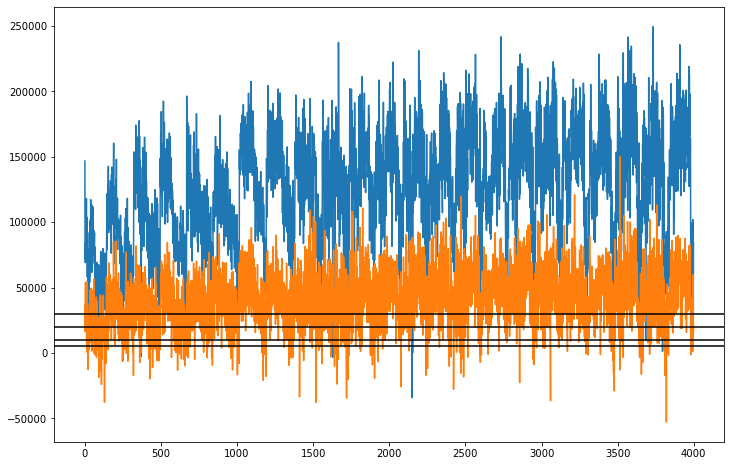

In [569]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(np.trapz(data_filtered['open'], axis = 1))
ax.plot(np.trapz(data_filtered['closed'], axis = 1))
ax.axhline(5e3, color = 'k')
ax.axhline(1e4, color = 'k')
ax.axhline(2e4, color = 'k')
ax.axhline(3e4, color = 'k')